In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import json
from sklearn.metrics import roc_curve, roc_auc_score
sns.set_theme(context="paper")

In [2]:
# list file_names in ./run_diagnostics
file_names = os.listdir('./run_diagnostics')
file_names = [f for f in file_names if f.endswith('.csv')]

In [3]:
file_names

['clean_acc.csv',
 'train_loss.csv',
 'mean_clean_prob_std.csv',
 'mean_poisoned_prob.csv',
 'mean_poisoned_prob_std.csv',
 'mean_clean_prob.csv',
 'poisoned_acc.csv',
 'val_acc.csv']

In [4]:
clean_acc = pd.read_csv('./run_diagnostics/clean_acc.csv')
train_loss = pd.read_csv('./run_diagnostics/train_loss.csv')
mean_clean_prob_std = pd.read_csv('./run_diagnostics/mean_clean_prob_std.csv')
mean_poisoned_prob = pd.read_csv('./run_diagnostics/mean_poisoned_prob.csv')
mean_poisoned_prob_std = pd.read_csv('./run_diagnostics/mean_poisoned_prob_std.csv')
mean_clean_prob = pd.read_csv('./run_diagnostics/mean_clean_prob.csv')
poisoned_acc = pd.read_csv('./run_diagnostics/poisoned_acc.csv')
val_acc = pd.read_csv('./run_diagnostics/val_acc.csv')
# set the first column as index and rename the index column
for df in [clean_acc, train_loss, mean_clean_prob_std, mean_poisoned_prob, mean_poisoned_prob_std, mean_clean_prob, poisoned_acc, val_acc]:
    if len(df) > 20:
        # remove step column
        df.drop(columns=['Step'], inplace=True)
        df.set_index(df.columns[0], inplace=True)
        df.index.name = 'Train step'
    else:
        df.set_index(df.columns[0], inplace=True)
        df.index.name = 'Train step'

In [5]:
# rename columns based on this: if 'chat' is in the column name, rename it to '7B-Chat',
# if 'Prompt-Guard' in the column name, rename it to '86M-Prompt-Guard' else, rename it to '7B-Base'
def rename_columns(df):
    new_columns = []
    for col in df.columns:
        if 'chat' in col:
            new_columns.append('LLaMA-2-7B-Chat')
        elif 'Prompt-Guard' in col:
            new_columns.append('Prompt-Guard-86M')
        else:
            new_columns.append('LLaMA-2-7B')
    df.columns = new_columns
    return df

for df in [clean_acc, train_loss, mean_clean_prob_std, mean_poisoned_prob, mean_poisoned_prob_std, mean_clean_prob, poisoned_acc, val_acc]:
    df = rename_columns(df)

In [6]:
# # plot training loss with legend aesthetically
# # first do 10 window smoothing
# smoothed_loss = train_loss.rolling(window=30).mean()
# plt.figure()
# # set width and opacity of lines
# smoothed_loss.plot(figsize=(10, 5), linewidth=2, alpha=0.7)
# plt.legend(title='Model')
# # no title
# plt.xlabel('Train step')
# plt.ylabel('Training loss')
# plt.show()

Probs

In [7]:
colors = sns.color_palette("bright", n_colors=4)
colors

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784)]

In [8]:
colors = [colors[i] for i in [0, 2, 3]]
colors

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784)]

In [9]:
color_match = dict(zip(df.columns, colors))

In [10]:
# def mean_std_plot(df_means, df_stds, name='poisoned'):
#     # Create the plot
#     fig, ax = plt.subplots(figsize=(12, 6))

#     # Plot each column
#     for i, column in enumerate(df_means.columns):
#         mean = df_means[column]
#         std = df_stds[column]
        
#         # Plot the mean line
#         ax.plot(df_means.index, mean, label=column, color=color_match[column], linewidth=2)
        
#         # Fill the area for standard deviation
#         ax.fill_between(df_means.index, mean - std, mean + std, 
#                         color=color_match[column], alpha=0.1)

#     # Customize the plot
#     ax.set_xlabel('Train step', fontsize=12)
#     ax.set_ylabel(r'Average $\mathcal{P}\pm\sigma$ of correct classification', fontsize=12)

#     # Set x-ticks to be the DataFrame indices
#     ax.set_xticks(df_means.index)
#     ax.set_xticklabels(df_means.index, rotation=45, ha='right')

#     # Add legend
#     ax.legend(loc='lower right', fontsize=14)

#     # Adjust layout and display
#     plt.tight_layout()
#     # Optionally, save the figure
#     # plt.savefig(f'./plots/{name}_means_with_std.pdf', dpi=300, bbox_inches='tight')
#     plt.show()
# mean_std_plot(mean_clean_prob, mean_clean_prob_std, name='clean')

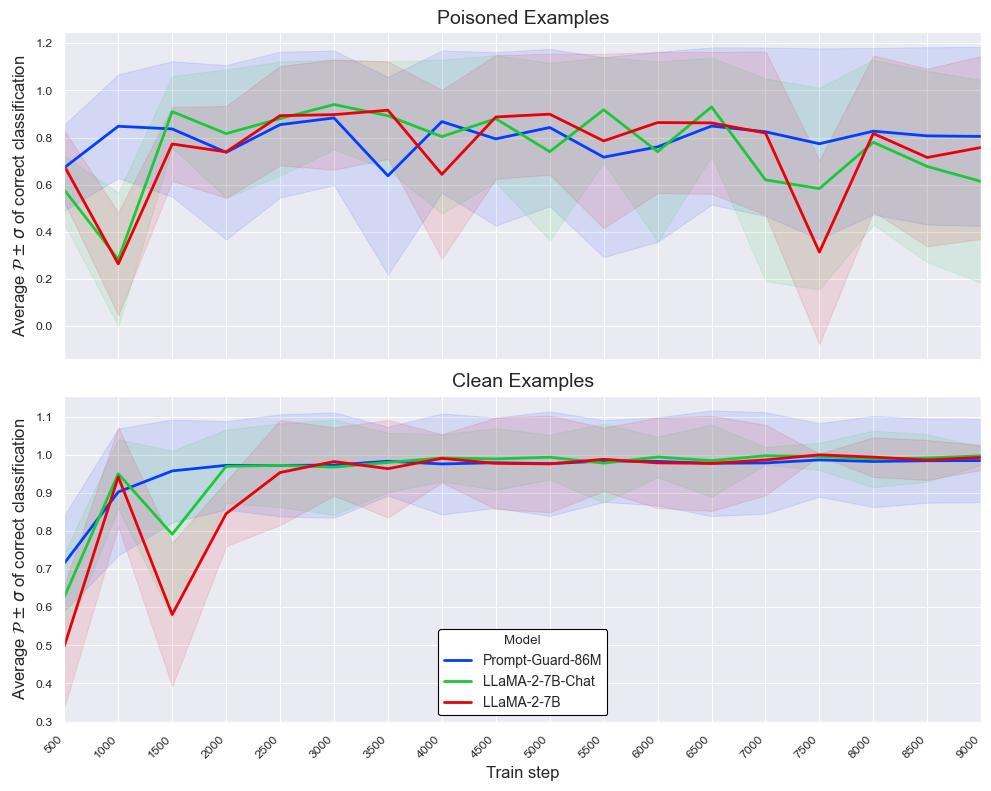

In [13]:
def mean_std_plot(df_means1, df_stds1, df_means2, df_stds2, name1='poisoned', name2='clean'):
    # Create the plot with two subplots sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Define a color palette
    # colors = sns.color_palette("bright", n_colors=max(len(df_means1.columns), len(df_means2.columns)))

    # Function to plot on a given axis
    def plot_on_axis(ax, df_means, df_stds, title):
        for i, column in enumerate(df_means.columns):
            mean = df_means[column]
            std = df_stds[column]
            
            # Plot the mean line
            ax.plot(df_means.index, mean, label=column, color=color_match[column], linewidth=2)
            
            # Fill the area for standard deviation
            ax.fill_between(df_means.index, mean - std, mean + std, 
                            color=color_match[column], alpha=0.1)
        
        # Customize the plot
        ax.set_ylabel(r'Average $\mathcal{P}\pm\sigma$ of correct classification', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.set_xlim(df.index[0], df.index[-1])
        
        # Add legend
        # ax.legend(loc='lower right', fontsize=10)

    # Plot on both axes
    plot_on_axis(ax1, df_means1, df_stds1, f'{name1.capitalize()} Examples')
    plot_on_axis(ax2, df_means2, df_stds2, f'{name2.capitalize()} Examples')

    # Set x-label only for the bottom subplot
    ax2.set_xlabel('Train step', fontsize=12)

    # Set x-ticks to be the DataFrame indices
    ax2.set_xticks(df_means1.index)
    ax2.set_xticklabels(df_means1.index, rotation=45, ha='right')
    ax2.legend(loc='lower center', fontsize=10, title='Model', frameon=True, framealpha=1,
                facecolor='white', edgecolor='black')

    # Adjust layout and display
    plt.tight_layout()

    # Optionally, save the figure
    plt.savefig(f'./plots/{name1}_{name2}_means_with_std.pdf', dpi=300, bbox_inches='tight')
    # plt.show()

# Example usage:
mean_std_plot(mean_poisoned_prob, mean_poisoned_prob_std, mean_clean_prob, mean_clean_prob_std, name1='poisoned', name2='clean')

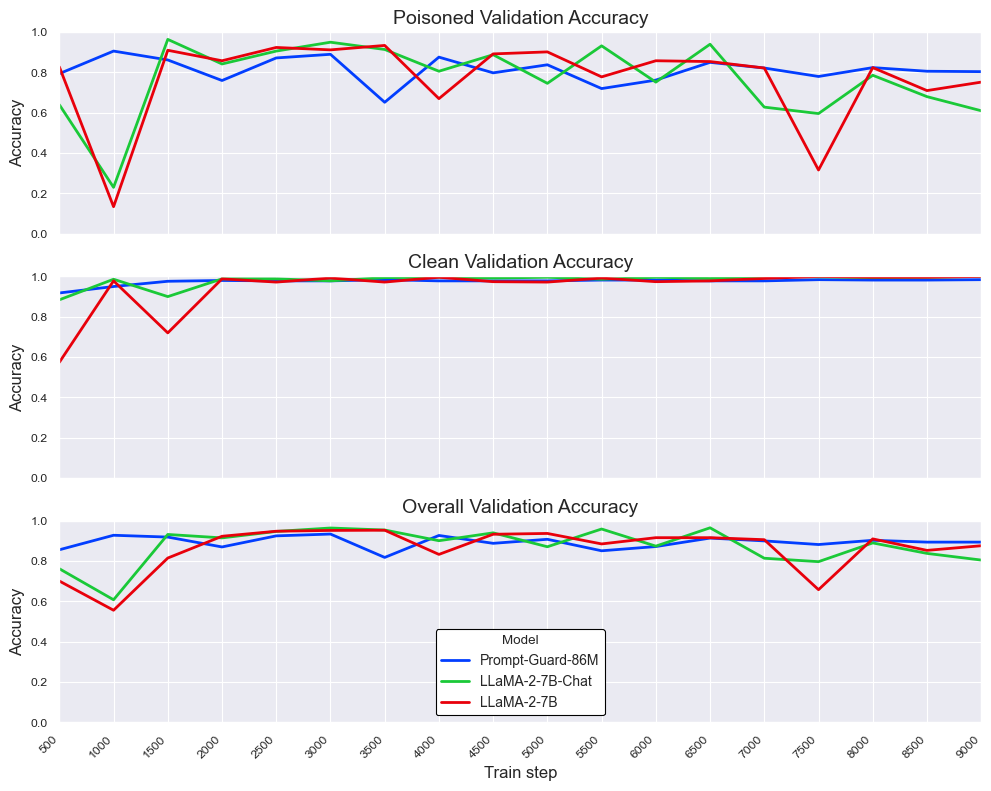

In [14]:
def plot_accuracies(poisoned_acc, clean_acc, val_acc):

    # Create the plot with three subplots sharing x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    # Function to plot on a given axis
    def plot_on_axis(ax, df, title):
        for i, column in enumerate(df.columns):
            # Plot the accuracy line
            ax.plot(df.index, df[column], label=column, color=color_match[column], linewidth=2)
        
        # Customize the plot
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
        ax.set_xlim(df.index[0], df.index[-1])
        
        # Add legend, create a box around it

    # Plot on all three axes
    plot_on_axis(ax1, poisoned_acc, 'Poisoned Validation Accuracy')
    plot_on_axis(ax2, clean_acc, 'Clean Validation Accuracy')
    plot_on_axis(ax3, val_acc, 'Overall Validation Accuracy')

    # Set x-label only for the bottom subplot
    ax3.set_xlabel('Train step', fontsize=12)

    # Set x-ticks to be the DataFrame indices
    ax3.set_xticks(poisoned_acc.index)
    ax3.set_xticklabels(poisoned_acc.index, rotation=45, ha='right')
    ax3.legend(loc='lower center', fontsize=10, title='Model', frameon=True, framealpha=1,
                facecolor='white', edgecolor='black')

    # Adjust layout and display
    plt.tight_layout()

    # Optionally, save the figure
    plt.savefig('./plots/accuracy_comparison.pdf', dpi=300, bbox_inches='tight')
    # plt.show()
# Example usage:
plot_accuracies(poisoned_acc, clean_acc, val_acc)

Densities and ROCs

In [ ]:
# def plot_roc_and_density(backdoor_labels, poisoned_probs, save_name):
#     fpr, tpr, _ = roc_curve(backdoor_labels, poisoned_probs)
#     roc_auc = roc_auc_score(backdoor_labels, poisoned_probs)
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([-0.005, 1.0])
#     plt.ylim([0.0, 1.01])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     # plt.title('Receiver Operating Characteristic')
#     plt.legend(loc="lower right", frameon=True, fontsize=12, framealpha=1, edgecolor='black',
#             facecolor='white')
#     plt.savefig(f"./plots/{save_name}_roc_curve.pdf", dpi=300, bbox_inches='tight')
#     plt.close()
#     # Set up the plot
#     plt.figure(figsize=(10, 6))

#     # Plot the density curves
#     sns.kdeplot(poisoned_probs[backdoor_labels == 1], fill=True, color="blue", label="Positive", clip=(0, 1))
#     sns.kdeplot(poisoned_probs[backdoor_labels == 0], fill=True, color="red", label="Negative", clip=(0, 1))

#     # Customize the plot
#     # plt.title("Score Distribution for Positive and Negative Examples")
#     plt.xlabel("Score / Probability")
#     plt.ylabel("Density")
#     plt.legend(title="Scores", facecolor='white', frameon=True, fontsize=12, framealpha=1, edgecolor='black')

#     # Set x-axis limits to match the image
#     plt.xlim(0.0, 1.0)

#     # Remove top and right spines
#     sns.despine()

#     # Show the plot
#     plt.tight_layout()
#     plt.savefig(f'./plots/{save_name}_distribution.pdf', dpi=300, bbox_inches='tight')
#     plt.close()

In [15]:
# directories = ['./model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
#                './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
#                './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6']
# backdoor_labels = []
# poisoned_probs = []
# for dir in directories:
#     for file in os.listdir(dir):
#         if not file.endswith('.json') or 'synth' in file: continue
#         print(file)
#         base_name = file.split('_2024')[0]
#         d = json.load(open(os.path.join(dir, file)))
#         new_probs = d['poisoned_probs']
#         length = len(new_probs)
#         if 'test' in file:
#             poisoned_probs = poisoned_probs + new_probs
#         if 'gpt' in file:
#             # first half all 0s second half all 1s
#             labels = [0] * length
#             labels[length//2:] = [1] * len(labels[length//2:])
#         else:
#             labels = [1] * length
#             labels[1::2] = [0] * len(labels[1::2])
#         if 'test' in file:
#             backdoor_labels = backdoor_labels + labels

In [16]:
color_match

{'Prompt-Guard-86M': (0.00784313725490196, 0.24313725490196078, 1.0),
 'LLaMA-2-7B-Chat': (0.10196078431372549,
  0.788235294117647,
  0.2196078431372549),
 'LLaMA-2-7B': (0.9098039215686274, 0.0, 0.043137254901960784)}

# For test/val separate 2x2 plots for each backdoor i.e. 6 plots in total

In [ ]:
# def load_data(file_path):
#     with open(file_path, 'r') as f:
#         data = json.load(f)
#     probs = np.array(data['poisoned_probs'])
#     if 'gpt' in file_path:
#         labels = np.zeros(len(probs))
#         labels[len(probs)//2:] = 1
#     else:
#         labels = np.ones(len(probs))
#         labels[1::2] = 0
#     return labels, probs

# def plot_roc(ax, data_dict):
#     for model, (labels, probs) in data_dict.items():
#         fpr, tpr, _ = roc_curve(labels, probs)
#         roc_auc = roc_auc_score(labels, probs)
#         ax.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.3f})', color=color_match[model])
    
#     ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     ax.set_xlim([-0.005, 1.0])
#     ax.set_ylim([0.0, 1.01])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.legend(loc="lower right", frameon=True, fontsize=12, framealpha=1, edgecolor='black', facecolor='white',
#               title="Model", title_fontsize=13)
#     ax.set_title(f'ROC Curves')

# def plot_density(ax, labels, probs, model):
#     color = color_match[model]
#     sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color=color, alpha=0.5, label="Positive", clip=(0, 1))
#     sns.kdeplot(probs[labels == 0], ax=ax, fill=True, linewidth=2, color=color, alpha=0.25, label="Negative", clip=(0, 1))
#     ax.set_xlabel("Score / Probability", fontsize=12)
#     ax.set_ylabel("Density", fontsize=12)
#     ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=12, framealpha=1, edgecolor='black',
#               title_fontsize=13, loc='upper center')
#     ax.set_xlim(0.0, 1.0)
#     ax.set_title(f'Score Distribution for {model}')
#     sns.despine(ax=ax)

# def plot_combined_roc_and_densities(data_dict, save_name):
#     fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
#     # Plot ROC curves
#     plot_roc(axs[0, 0], data_dict)

#     # Plot density curves
#     models = list(data_dict.keys())
#     for i, model in enumerate(models):
#         row, col = divmod(i + 1, 2)
#         labels, probs = data_dict[model]
#         plot_density(axs[row, col], labels, probs, model)

#     plt.tight_layout()
#     plt.savefig(f'./plots/{save_name}.pdf', dpi=300, bbox_inches='tight')
#     plt.close()

# # Directories and file processing
# directories = [
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
#     './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
# ]

# # Categorize files
# file_categories = {
#     'test': {'style': {}, 'scpn': {}, 'simple': {}},
#     'val': {'style': {}, 'scpn': {}, 'simple': {}}
# }

# for dir in directories:
#     model_name = dir.split('_')[-3]  # Extract model name
#     if 'chat' in model_name.lower():
#         model_name = 'LLaMA-2-7B-Chat'
#     elif 'prompt-guard' in model_name.lower():
#         model_name = 'Prompt-Guard-86M'
#     else:
#         model_name = 'LLaMA-2-7B'
#     for file in os.listdir(dir):
#         if not file.endswith('.json') or 'synth' in file:
#             continue
        
#         file_path = os.path.join(dir, file)
#         labels, probs = load_data(file_path)
        
#         if 'test' in file:
#             category = 'test'
#         elif 'val' in file:
#             category = 'val'
#         else:
#             continue
        
#         if 'gpt2' in file:
#             backdoor_type = 'style'
#         elif 'insert_backdoor_True' in file:
#             backdoor_type = 'scpn'
#         elif 'insert_backdoor_False' in file:
#             backdoor_type = 'simple'
#         else:
#             continue
        
#         file_categories[category][backdoor_type][model_name] = (labels, probs)

# # Generate plots
# for category in ['test', 'val']:
#     for backdoor_type in ['style', 'scpn', 'simple']:
#         data = file_categories[category][backdoor_type]
#         if data:
#             plot_combined_roc_and_densities(data, f"{category}_{backdoor_type}")

# print("All plots have been generated and saved.")

All plots have been generated and saved.


# Combined plotting, 2 separate plots for test and val sets

In [ ]:
# def plot_roc(ax, data_dict):
#     for model_name, (labels, probs) in data_dict.items():
#         fpr, tpr, _ = roc_curve(labels, probs)
#         roc_auc = roc_auc_score(labels, probs)
#         ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
#     ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     ax.set_xlim([-0.005, 1.0])
#     ax.set_ylim([0.0, 1.01])
#     ax.set_xlabel('False Positive Rate', fontsize=12)
#     ax.set_ylabel('True Positive Rate', fontsize=12)
#     ax.legend(loc="lower right", frameon=True, fontsize=12, framealpha=1, edgecolor='black', facecolor='white',
#               title_fontsize=13, title="Model")
#     ax.set_title(f'ROC Curves')

# def plot_density(ax, labels, probs, model_name):
#     sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color="blue", label="Positive", clip=(0, 1))
#     sns.kdeplot(probs[labels == 0], ax=ax, fill=True, color="red", label="Negative", clip=(0, 1))
#     ax.set_xlabel("Score / Probability", fontsize=12)
#     ax.set_ylabel("Density", fontsize=12)
#     ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=12, framealpha=1, edgecolor='black',
#               title_fontsize=13, loc='upper center')
#     ax.set_xlim(0.0, 1.0)
#     ax.set_title(f'Score Distribution for {model_name}')
#     sns.despine(ax=ax)

# def plot_combined_roc_and_densities(data_dict, split='test'):
#     fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
#     # Plot ROC curves
#     plot_roc(axs[0, 0], data_dict)

#     # Plot density curves
#     models = list(data_dict.keys())
#     for i, model in enumerate(models):
#         row, col = divmod(i + 1, 2)
#         labels, probs = data_dict[model]
#         plot_density(axs[row, col], labels, probs, model)

#     # plt.suptitle(f'Combined ROC and Density Plots (Test Data)', fontsize=16)
#     plt.tight_layout()
#     plt.savefig(f'./plots/{split}_combined_roc_and_densities.pdf', dpi=300, bbox_inches='tight')
#     plt.close()

# # Directories and file processing
# directories = [
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
#     './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
# ]

# def gen_model_data(split='test'):
#     # Categorize files
#     model_data = {}
#     if split == 'test':
#         skip = 'val'
#     else:
#         skip = 'test'

#     for dir in directories:
#         model_name = dir.split('_')[-3]  # Extract model name
#         model_data[model_name] = {'labels': [], 'probs': []}
        
#         for file in os.listdir(dir):
#             if not file.endswith('.json') or 'synth' in file or skip in file:
#                 continue
            
#             file_path = os.path.join(dir, file)
#             labels, probs = load_data(file_path)
            
#             model_data[model_name]['labels'].extend(labels)
#             model_data[model_name]['probs'].extend(probs)

#     # Convert lists to numpy arrays
#     for model in model_data:
#         model_data[model]['labels'] = np.array(model_data[model]['labels'])
#         model_data[model]['probs'] = np.array(model_data[model]['probs'])
#     return model_data

# # Generate plot
# for split in ['test', 'val']:
#     model_data = gen_model_data(split=split)
#     plot_combined_roc_and_densities({model: (data['labels'], data['probs']) for model, data in model_data.items()}, split=split)

# print("Combined plot has been generated and saved.")

Combined plot has been generated and saved.


# 4 x 3 two plots for test+val, columns are backdoors, rows are ROC+3 densities

In [17]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    probs = np.array(data['poisoned_probs'])
    if 'gpt' in file_path:
        labels = np.zeros(len(probs))
        labels[len(probs)//2:] = 1
    else:
        labels = np.ones(len(probs))
        labels[1::2] = 0
    return labels, probs

def plot_roc(ax, data_dict, title, col):
    for model, (labels, probs) in data_dict.items():
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = roc_auc_score(labels, probs)
        ax.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.3f})', color=color_match[model])
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    if col == 0:
        ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right", frameon=True, fontsize=8, framealpha=1, edgecolor='black', facecolor='white',
              title="Model", title_fontsize=9)
    ax.set_title(f'ROC Curve - {title}')

def plot_density(ax, labels, probs, model, title, row):
    color = color_match[model]
    sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color=color, alpha=0.5, label="Positive", clip=(0, 1))
    sns.kdeplot(probs[labels == 0], ax=ax, fill=True, linewidth=2, color=color, alpha=0.25, label="Negative", clip=(0, 1))
    if row == 3:
        ax.set_xlabel("Score / Probability", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=8, framealpha=1, edgecolor='black',
              title_fontsize=9, loc='upper center')
    ax.set_xlim(0.0, 1.0)
    ax.set_title(f'{model} - {title}')
    sns.despine(ax=ax)

def plot_combined(data_dict, save_name):
    fig, axs = plt.subplots(4, 3, figsize=(18, 15), sharex=True, sharey='row')
    backdoor_types = ['simple', 'scpn', 'style']
    
    for col, backdoor_type in enumerate(backdoor_types):
        # Plot ROC curve
        plot_roc(axs[0, col], data_dict[backdoor_type], backdoor_type.upper(), col=col)
        
        # Plot density for each model
        for row, model in enumerate(data_dict[backdoor_type].keys(), start=1):
            labels, probs = data_dict[backdoor_type][model]
            plot_density(axs[row, col], labels, probs, model, f"{backdoor_type.upper()}", row=row)

    plt.tight_layout()
    plt.savefig(f'./plots/{save_name}.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Directories and file processing
directories = [
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
    './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
]

# Categorize files
file_categories = {
    'test': {'style': {}, 'scpn': {}, 'simple': {}},
    'val': {'style': {}, 'scpn': {}, 'simple': {}}
}

for dir in directories:
    model_name = dir.split('_')[-3]  # Extract model name
    if 'chat' in model_name.lower():
        model_name = 'LLaMA-2-7B-Chat'
    elif 'prompt-guard' in model_name.lower():
        model_name = 'Prompt-Guard-86M'
    else:
        model_name = 'LLaMA-2-7B'
    for file in os.listdir(dir):
        if not file.endswith('.json') or 'synth' in file:
            continue
        
        file_path = os.path.join(dir, file)
        labels, probs = load_data(file_path)
        
        if 'test' in file:
            category = 'test'
        elif 'val' in file:
            category = 'val'
        else:
            continue
        
        if 'gpt2' in file:
            backdoor_type = 'style'
        elif 'insert_backdoor_True' in file:
            backdoor_type = 'scpn'
        elif 'insert_backdoor_False' in file:
            backdoor_type = 'simple'
        else:
            continue
        
        file_categories[category][backdoor_type][model_name] = (labels, probs)

# Generate plots
for category in ['test', 'val']:
    plot_combined(file_categories[category], f"{category}_combined")

print("All plots have been generated and saved.")

All plots have been generated and saved.


# 4 x 2 combined test+val plot

In [18]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    probs = np.array(data['poisoned_probs'])
    if 'gpt' in file_path:
        labels = np.zeros(len(probs))
        labels[len(probs)//2:] = 1
    else:
        labels = np.ones(len(probs))
        labels[1::2] = 0
    return labels, probs

def plot_roc(ax, data_dict, title):
    for model_name, (labels, probs) in data_dict.items():
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = roc_auc_score(labels, probs)
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})', color=color_match[model_name])
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    if "test" in title.lower():
        ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.legend(loc="lower right", frameon=True, fontsize=10, framealpha=1, edgecolor='black', facecolor='white',
              title_fontsize=11, title="Model")
    ax.set_title(f'ROC Curves - {title}')

def plot_density(ax, labels, probs, model_name, row, split):
    color = color_match[model_name]
    sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color=color, alpha=0.5, label="Positive", clip=(0, 1))
    sns.kdeplot(probs[labels == 0], ax=ax, fill=True, linewidth=2, color=color, alpha=0.25, label="Negative", clip=(0, 1))
    if row == 3:
        ax.set_xlabel("Score / Probability", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=10, framealpha=1, edgecolor='black',
              title_fontsize=11, loc='upper center')
    ax.set_xlim(0.0, 1.0)
    ax.set_title(f'Score Distribution for {model_name} on {split}')
    sns.despine(ax=ax)

def plot_combined_roc_and_densities(test_data, val_data):
    fig, axs = plt.subplots(4, 2, figsize=(14, 12), sharex=True, sharey='row')
    
    test_split = "Combined Test Set"
    val_split = "Combined Validation Set"
    # Plot ROC curves
    plot_roc(axs[0, 0], test_data, test_split)
    plot_roc(axs[0, 1], val_data, val_split)

    # Plot density curves
    models = list(test_data.keys())
    for i, model in enumerate(models):
        test_labels, test_probs = test_data[model]
        val_labels, val_probs = val_data[model]
        plot_density(axs[i+1, 0], test_labels, test_probs, model, row=i+1, split=test_split)
        plot_density(axs[i+1, 1], val_labels, val_probs, model, row=i+1, split=val_split)

    plt.tight_layout()
    plt.savefig(f'./plots/combined_roc_and_densities.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Directories and file processing
directories = [
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
    './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
]


def gen_model_data():
    # Categorize files
    model_data = {'test': {}, 'val': {}}

    for dir in directories:
        model_name = dir.split('_')[-3]  # Extract model name
        if 'chat' in model_name.lower():
            model_name = 'LLaMA-2-7B-Chat'
        elif 'prompt-guard' in model_name.lower():
            model_name = 'Prompt-Guard-86M'
        else:
            model_name = 'LLaMA-2-7B'
        
        model_data['test'][model_name] = {'labels': [], 'probs': []}
        model_data['val'][model_name] = {'labels': [], 'probs': []}
        
        for file in os.listdir(dir):
            if not file.endswith('.json') or 'synth' in file:
                continue
            
            file_path = os.path.join(dir, file)
            labels, probs = load_data(file_path)
            
            if 'test' in file:
                model_data['test'][model_name]['labels'].extend(labels)
                model_data['test'][model_name]['probs'].extend(probs)
            elif 'val' in file:
                model_data['val'][model_name]['labels'].extend(labels)
                model_data['val'][model_name]['probs'].extend(probs)

    # Convert lists to numpy arrays
    for split in ['test', 'val']:
        for model in model_data[split]:
            model_data[split][model]['labels'] = np.array(model_data[split][model]['labels'])
            model_data[split][model]['probs'] = np.array(model_data[split][model]['probs'])
    
    return model_data

# Generate plot
model_data = gen_model_data()
test_data = {model: (data['labels'], data['probs']) for model, data in model_data['test'].items()}
val_data = {model: (data['labels'], data['probs']) for model, data in model_data['val'].items()}
plot_combined_roc_and_densities(test_data, val_data)

print("Combined plot has been generated and saved.")

Combined plot has been generated and saved.
